Here it will be something like wavenet

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

/home/artof/envs/fun/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchlike import Linear, BatchNorm1d, Tanh, FlattenConsecutive, Embedding, Sequential

In [3]:
words = open('./names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
chars = sorted(set(''.join(words)))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
import random
random.seed(42)
random.shuffle(words)
torch.manual_seed(42)

In [6]:
block_size = 8

def build_dataset(words, block_size=block_size):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


In [7]:
n1 = int(.8 * len(words))
n2 = int(.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [8]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [26]:
# 1 2 3 4 5 6 7 8
# (1 2) (3 4) (5 6) (7 8)

In [9]:
n_embd = 10
n_hidden = 68
model = Sequential([
    Embedding(num_embeddings=vocab_size, embedding_dim=n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

In [12]:
with torch.no_grad():
    model.layers[-1].weight *= .1
model.layers

In [13]:
model.train()

max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)
    
    loss = F.cross_entropy(logits, Yb)

    for p in model.parameters():
        p.grad = None
    
    loss.backward()

    lr = 0.1 if i < 150_000 else 0.01
    for p in model.parameters():
        p.data += -lr * p.grad
    
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2975
  10000/ 200000: 2.2060
  20000/ 200000: 2.0583
  30000/ 200000: 2.0873
  40000/ 200000: 1.9474
  50000/ 200000: 2.3506
  60000/ 200000: 1.9712
  70000/ 200000: 1.8905
  80000/ 200000: 2.0082
  90000/ 200000: 1.9343
 100000/ 200000: 1.6828
 110000/ 200000: 2.5577
 120000/ 200000: 2.4411
 130000/ 200000: 1.9464
 140000/ 200000: 2.1424
 150000/ 200000: 1.7826
 160000/ 200000: 1.8638
 170000/ 200000: 2.1216
 180000/ 200000: 2.0026
 190000/ 200000: 1.7249


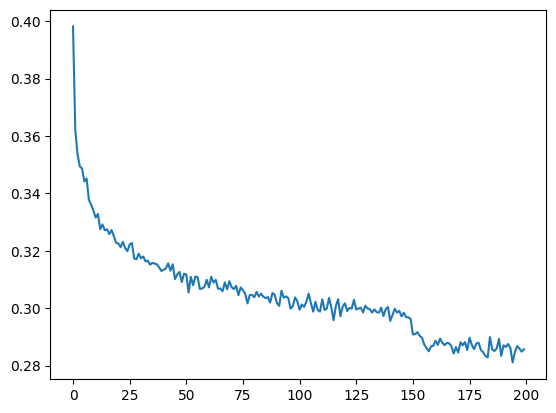

In [14]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [15]:
model.eval()
@torch.no_grad()
def split_loss(split_):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split_]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split_, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')


train 1.9112648963928223
val 2.021030902862549
test 2.0182292461395264


In [16]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

kamoni.
lihanna.
franco.
jaslara.
holi.
faynn.
romet.
judnni.
blaylah.
hason.
celabiana.
leandre.
laparita.
mckint.
lairah.
khyle.
annahsir.
gwindrym.
adden.
kelshe.


In [17]:
# Convolutions:
for x, y in zip(Xtr[7:15], Ytr[7:15]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [18]:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [20]:
logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(Xtr[[7 + i]])
logits.shape



torch.Size([8, 27])